## Playground: Weighting Strategies

In [ ]:
import os
import sys

# Needed to import modules from parent directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [1]:
from utils.database import *
from utils.files import *
from tqdm import tqdm
from bson import ObjectId
import pandas as pd 
import numpy as np

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_from_disk, Dataset, ClassLabel, Value, Features
from huggingface_hub import InferenceClient
from transformers import BertTokenizer
import matplotlib.pyplot as plt
from utils.preprocessing import *
from utils.accelerators import *
from utils.multithreading import *
from utils.database import *
from utils.model import *
from utils.files import *
from datasets import Dataset
from tqdm import tqdm
import statistics
import hashlib
import random
import time
import math
import re

/home/jschelb/.pyenv/versions/3.10.8/envs/s2j-content-analysis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

In [ ]:
topic = "kinder" #"energie" #"kinder" "cannabis"

## Get Predictions

### Load Model

In [ ]:
model_path = f"../models/bert_{topic}_model_buff"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path).eval()

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('Using device:', device)
# print()

# #Additional Info when using cuda
# if device.type == 'cuda':
#     print(torch.cuda.get_device_name(0))
#     print('Memory Usage:')
#     print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
#     print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
#     model.to(device)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = torch.nn.DataParallel(model)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Using 2 GPUs!


DataParallel(
  (module): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(31102, 1024, padding_idx=0)
        (position_embeddings): Embedding(512, 1024)
        (token_type_embeddings): Embedding(2, 1024)
        (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-23): 24 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=1024, out_features=1024, bias=True)
                (key): Linear(in_features=1024, out_features=1024, bias=True)
                (value): Linear(in_features=1024, out_features=1024, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=1024, out_fea

### Load Dataset

In [ ]:
#dataset = load_from_disk(f"../../data/tmp/processed_dataset_buff_{topic}_split_chunkified")
dataset = load_from_disk(f"../../data/tmp/processed_dataset_{topic}_buffed_chunkified_random")
#dataset_holdout = load_from_disk(f"../../data/tmp/processed_dataset_{topic}_buffed_chunkified_random_holdout")

In [ ]:
#dataset_negative_examples = dataset.filter(lambda example: example['label'] == 0)
#dataset_positive_examples = dataset.filter(lambda example: example['label'] == 1)

# Shuffle the dataset
#shuffled_dataset = dataset_negative_examples.shuffle(seed=42)

# Sample 6_000 random examples
#num_samples = 100_000
#sampled_dataset = shuffled_dataset.select(range(num_samples))

In [ ]:

# from datasets import concatenate_datasets
# dataset["test"] = concatenate_datasets([dataset["test"], dataset_holdout])
# dataset["test"] = dataset["test"].shuffle(seed=42)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'is_topic', 'label', 'chunk_id'],
        num_rows: 12389
    })
    test: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'is_topic', 'label', 'chunk_id'],
        num_rows: 1377
    })
})

In [ ]:
dataset = dataset["train"]

In [ ]:
# Tokenize the text
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

dataset = dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 12389/12389 [00:02<00:00, 4357.33 examples/s]


### Generate Labels

In [ ]:
def predict_batch(batch):
    """ Perform prediction on a batch of samples """
    
    input_ids = torch.tensor(batch['input_ids']).to(device)
    attention_mask = torch.tensor(batch['attention_mask']).to(device)
    
    # Perform prediction
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    # Extract probabilities and predicted classes
    batch['probas'] = predictions[:, 1].cpu().tolist()  # Move results back to CPU if needed
    batch['preds'] = torch.argmax(predictions, dim=-1).cpu().tolist()

    return batch


In [ ]:
dataset = dataset.map(predict_batch, batched=True, batch_size=1024)

Map:  17%|█▋        | 2048/12389 [00:47<03:59, 43.21 examples/s]


KeyboardInterrupt: 

In [ ]:
dataset.save_to_disk(f"../../data/tmp/processed_dataset_buff_{topic}_full_with_predictions")

Saving the dataset (1/1 shards): 100%|██████████| 295/295 [00:00<00:00, 35612.47 examples/s]


In [ ]:
#dataset = load_from_disk(f"../../data/tmp/processed_dataset_buff_{topic}_full_with_predictions")

In [ ]:
#dataset[0]["probas"]

In [ ]:
print("Length of dataset: ", len(dataset))

Length of dataset:  295


In [ ]:
# Group dataset examples by URL, with a fallback to domain
grouped_dataset = {}
for example in dataset:
    url = example.get("view_url") or example.get("domain")
    example_filted = {k: example[k] for k in ["text", "probas", "preds"]}
    grouped_dataset.setdefault(url, []).append(example_filted)

In [ ]:
list(grouped_dataset.keys())[0:10]

['hna.de/',
 'https://www.mdr.de/nachrichten/sachsen-anhalt/halle/halle/cannabis-legalisierung-risiken-interview-psychotherapeutin-sabine-ahrens-eipper-100.html',
 'https://www.zeit.de/politik/deutschland/2023-05/nrw-cannabis-legalisierung-stopp-bundesrat',
 'https://www.mdr.de/nachrichten/sachsen-anhalt/halle/saalekreis/cannabis-legalisierung-wirtschaft-steuern-chancen-100.html',
 'www.lotto-berlin.de/',
 'www.brak.de/newsroom/news/entwurf-fuer-cannabisgesetz-veroeffentlicht-was-steht-drin/',
 'dlcdnets.asus.com/pub/ASUS/LCD%20Monitors/PG27AQDM/ASUS_PG27AQDM_UM_German.pdf?model=PG27AQDM',
 'holsten-gewinnspiel.de/?error#mitmachen',
 'https://www.hanf-magazin.com/kolumnen/interviews/wie-siehts-aus-herr-blienert/',
 'surveyd.bilendi.com/survey/selfserve/53b/2306171?list=1&ID=247978414657656&x=5#?']

In [ ]:
#grouped_dataset["bundesgesundheitsministerium.de/themen/cannabis/faq-genuss-cannabis.html"]

## Extract Label

In [ ]:
# Extract labels
labels_for_url = []
for url, chunks in grouped_dataset.items():
    preds = [chunk["preds"] for chunk in chunks]
    labels_for_url.append(max(preds))

## Calculate Inter-URL Label Entropy

In [ ]:
from math import log2

def calculate_entropy(values):
    """Calculate the entropy of a list of values."""

    # Calculate the proportions of each label
    proportion_1 = sum(values) / len(values)
    proportion_0 = 1 - proportion_1
    
    # Handle cases where proportion is 0, since log2(0) is undefined
    if proportion_0 == 0 or proportion_1 == 0:
        return 0
    
    # Calculate entropy
    entropy = -(proportion_0 * log2(proportion_0) + proportion_1 * log2(proportion_1))
    return entropy

# Example usage
test_values = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
print(calculate_entropy(test_values))

# Example usage
test_values = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
print(calculate_entropy(test_values))

# Example usage
test_values = [0.0, 0.0, 0.0, 1.0, 1.0, 1.0]
print(calculate_entropy(test_values))

# Example usage
test_values = [0.0, 0.0, 0.0, 0.0, 1.0, 1.0]
print(calculate_entropy(test_values))

# Example usage
test_values = [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
print(calculate_entropy(test_values))


0
0
1.0
0.9182958340544896
0.6500224216483541


In [ ]:
prediction_for_url_entropy = []
chunks_per_url = []

for url, chunks in grouped_dataset.items():
    probas = [chunk["preds"] for chunk in chunks]
    prediction_for_url_entropy.append(calculate_entropy(probas))
    chunks_per_url.append(len(chunks))

In [ ]:
# Calculate the mean entropy
mean_entropy = statistics.mean(prediction_for_url_entropy)
print(mean_entropy)
print(np.mean(chunks_per_url))

0.007766379894957448
1.194331983805668


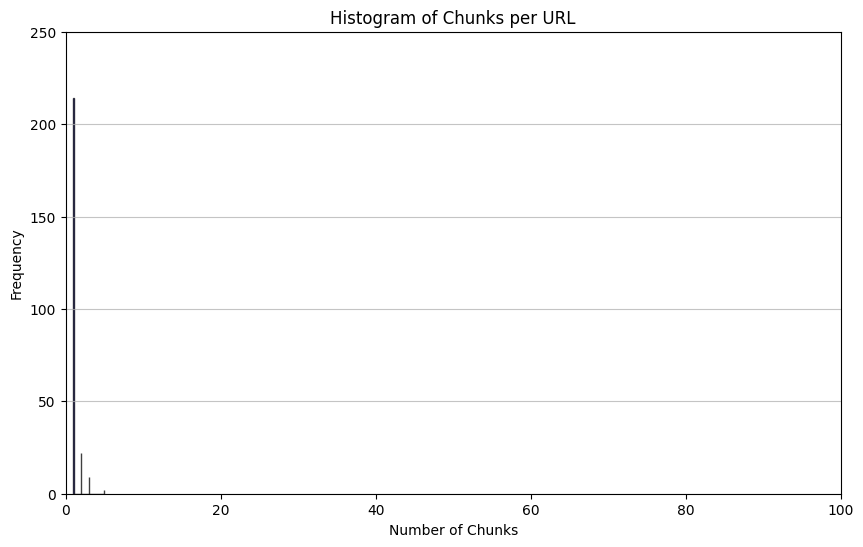

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(chunks_per_url, bins=200, alpha=0.75, color='blue', edgecolor='black')
plt.title('Histogram of Chunks per URL')
plt.xlabel('Number of Chunks')
plt.ylabel('Frequency')
plt.xlim([0, 100])  
plt.ylim([0, 250])
plt.grid(axis='y', alpha=0.75)
plt.show()

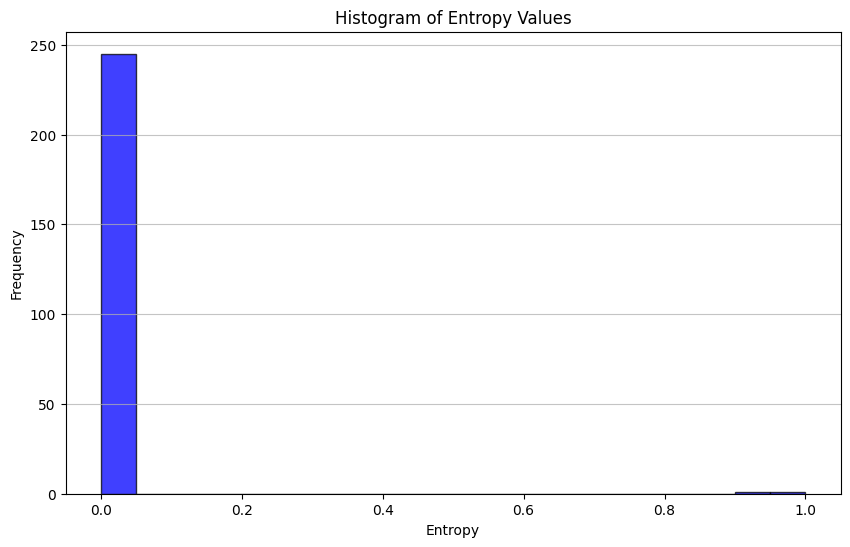

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(prediction_for_url_entropy, bins=20, alpha=0.75, color='blue', edgecolor='black')
plt.title('Histogram of Entropy Values')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

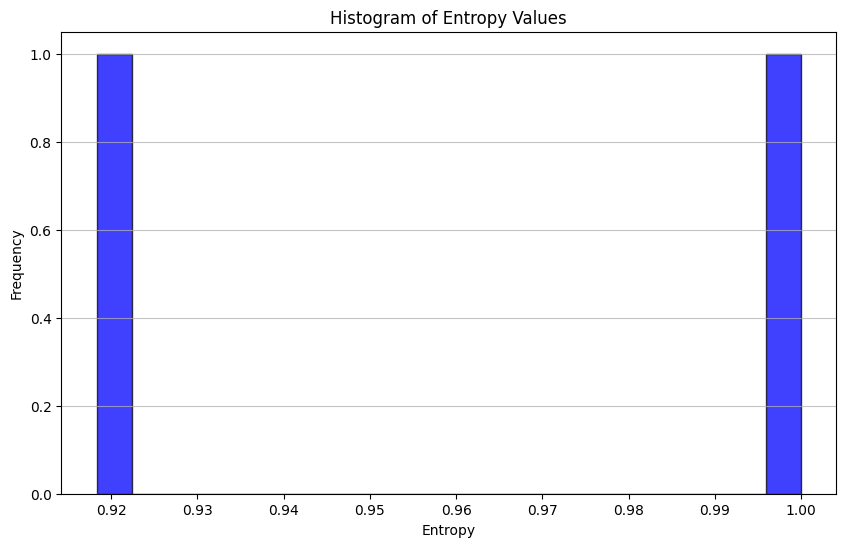

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist([value for value in prediction_for_url_entropy if value > 0], bins=20, alpha=0.75, color='blue', edgecolor='black')
plt.title('Histogram of Entropy Values')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
max_value = max(prediction_for_url_entropy)
position_of_max = prediction_for_url_entropy.index(max_value)
print(list(grouped_dataset.keys())[position_of_max])
list(grouped_dataset.values())[position_of_max]

https://regionalheute.de/entwurf-zur-cannabis-legalisierung-soll-bis-ende-maerz-vorliegen-1673967544/


[{'text': 'Anzeige Anzeige Anzeige Anzeige Anzeige Anzeige Anzeige Anzeige Anzeige Anzeige Anzeige Anzeige Anzeige Anzeige Anzeige',
  'probas': 0.004066812805831432,
  'preds': 0},
 {'text': 'Entwurf zur Cannabis - Legalisierung soll bis Ende März vorliegen | regionalHeute. de Region Sie sind hier : Region > Entwurf zur Cannabis - Legalisierung soll bis Ende März vorliegen Entwurf zur Cannabis - Legalisierung soll bis Ende März vorliegen Bundesgesundheitsminister Karl Lauterbach ( SPD ) will bis Ende März seinen Gesetzentwurf zur Legalisierung von Cannabis fertigstellen. von dts Nachrichtenagentur Symbolbild. | Foto : Über dts Nachrichtenagentur 17. 01. 2023, 15 : 59 Uhr Berlin. Bundesgesundheitsminister Karl Lauterbach ( SPD ) will bis Ende März seinen Gesetzentwurf zur Legalisierung von Cannabis fertigstellen. " Im ersten Quartal, denke ich schon, werden wir einen Gesetzentwurf vorgelegt haben ", sagte er dem Fernsehsender " Welt ". Sein Ministerium arbeite derzeit sehr intensiv an 

## Label per Text Chunk

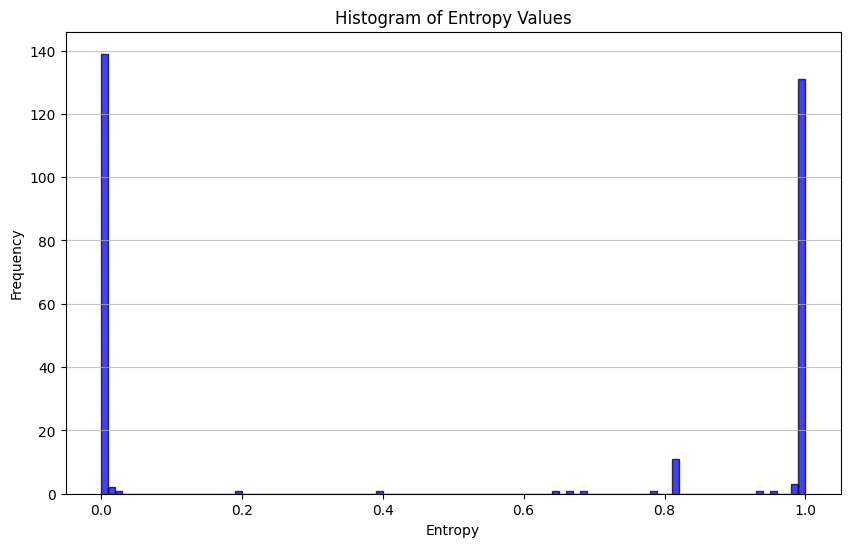

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(dataset["probas"], bins=100, alpha=0.75, color='blue', edgecolor='black')
plt.title('Histogram of Entropy Values')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
preds = dataset["preds"]
labels = dataset["label"]

In [ ]:
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

Accuracy: 94.92%
Precision: 0.93
Recall: 0.97
F1 Score: 0.95


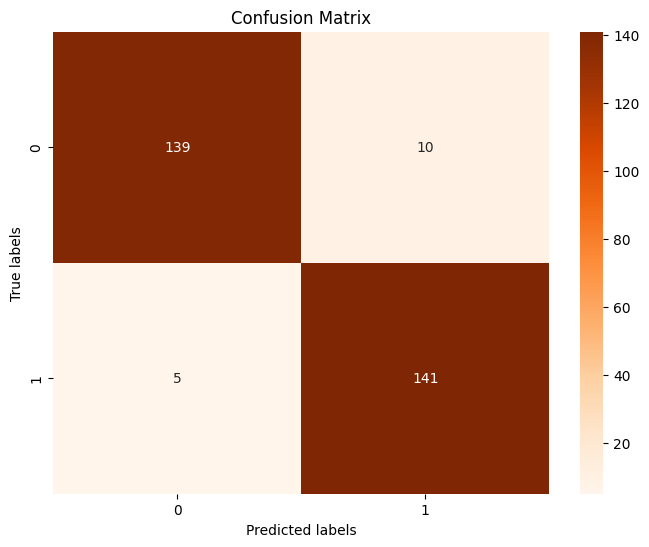

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming labels and preds are lists or arrays containing the true labels and predicted labels respectively
cm = confusion_matrix(labels, preds)

# Create a seaborn heatmap with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", cbar=True)

# Add labels and title
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")

# Show plot
plt.show()

In [ ]:
print(cm)

[[139  10]
 [  5 141]]


## Maximum Label
Classifying the entire document as in-class if at least one chunk of the document is identified as policy relevant.

In [ ]:
prediction_for_url_max = []

for url, chunks in grouped_dataset.items():
    probas = [chunk["preds"] for chunk in chunks]
    prediction_for_url_max.append(max(probas))

In [ ]:
len(labels_for_url)

247

In [ ]:
accuracy = accuracy_score(labels_for_url, prediction_for_url_max)
precision = precision_score(labels_for_url, prediction_for_url_max)
recall = recall_score(labels_for_url, prediction_for_url_max)
f1 = f1_score(labels_for_url, prediction_for_url_max)

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


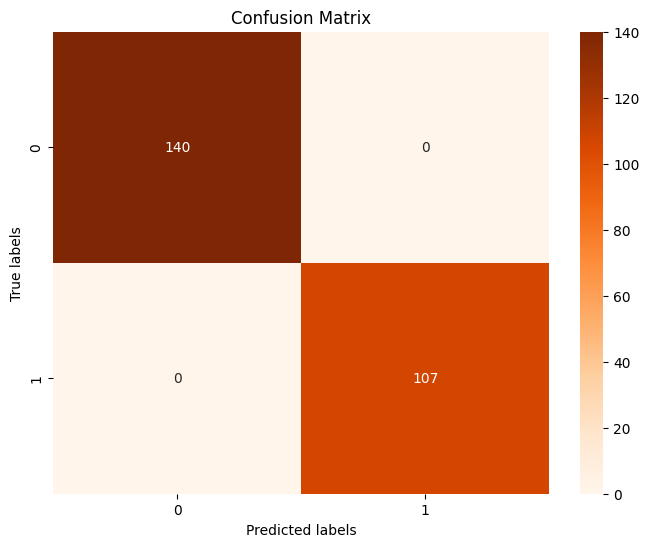

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming labels and preds are lists or arrays containing the true labels and predicted labels respectively
cm = confusion_matrix(labels_for_url, prediction_for_url_max)

# Create a seaborn heatmap with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", cbar=True)

# Add labels and title
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")

# Show plot
plt.show()

## Averaging Probabilities

Computing the average probability across all content chunks
and applying a classification threshold, with
an equal weight distribution of 50% each to
the URL classification and the aggregate con-
tent chunks’ classification.

In [ ]:
prediction_for_url_avg = []

for url, chunks in grouped_dataset.items():
    probas = [chunk["probas"] for chunk in chunks]
    prediction_for_url_avg.append(round(np.mean(probas)))
    

In [ ]:
accuracy = accuracy_score(labels_for_url, prediction_for_url_avg)
precision = precision_score(labels_for_url, prediction_for_url_avg)
recall = recall_score(labels_for_url, prediction_for_url_avg)
f1 = f1_score(labels_for_url, prediction_for_url_avg)

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

Accuracy: 100.00%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


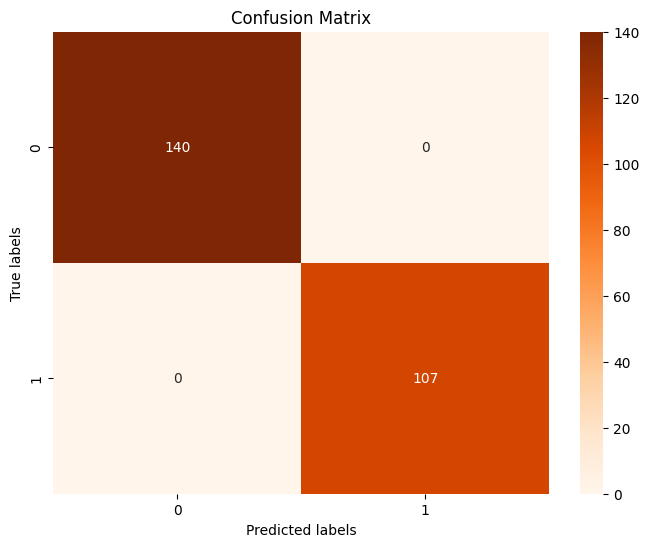

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming labels and preds are lists or arrays containing the true labels and predicted labels respectively
cm = confusion_matrix(labels_for_url, prediction_for_url_avg)

# Create a seaborn heatmap with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", cbar=True)

# Add labels and title
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")

# Show plot
plt.show()

In [ ]:
count = 0

print("Displaying URLs with Incorrect Predictions\n" + "-"*50)
# Loop through grouped dataset items
for i, (url, chunks) in enumerate(grouped_dataset.items()):
    # Check if the label does not match the prediction
    if labels_for_url[i] != prediction_for_url_avg[i]:
        count += 1
        print(f"URL: {url}")
        print(f"Actual Label: {labels_for_url[i]}")
        print(f"Predicted Average: {prediction_for_url_avg[i]}\n")
        
        print("Text Chunks with Predictions:")
        # Loop through each chunk for the current URL
        for chunk in chunks:
            text = chunk["text"]
            probas = chunk["probas"]
            preds = chunk["preds"]
            print(f"Text: {text}")
            print(f"Probabilities: {probas}")
            print(f"Predictions: {preds}\n")
        print("-"*50)
        
    # Break the loop after displaying 5 URLs
    if count > 5:
        print("Displayed 5 URLs with incorrect predictions. Stopping...\n")
        break


Displaying URLs with Incorrect Predictions
--------------------------------------------------
URL: pfarreiengemeinschaft-burgau.de/kirchen-kapellen
Actual Label: 1
Predicted Average: 0

Text Chunks with Predictions:
Text: Navigation aufklappen / zuklappen Startseite Wer wir sind Stadtpfarrer Diakon Gemeindereferentin Kirchenverwaltung Pfarrgemeinderat Mesner Organisten Kontakt Sakramente Taufe Erstkommunion Versöhnung ( Beichte ) Firmung Ehe Krankensalbung Gruppen Kolping Allgemeines Gruppierungen / Ansprechpartner Veranstaltungen im Jahreskreis Aktuelle Termine Berichte / Historisches Krabbelgruppe Kleinkindergottesdienst Krippenfreunde Burgau Ministranten Jugendgruppe Limbach Pfadfinder Pfarrbücherei Frauenbund Burgau Frauenbund Unterknöringen Kirchenchor Burgau Chorausflug 2015 Kirchenchor Unterknöringen Seniorengruppe Unterknöringen Seniorengruppe Limbach Kita Hl. Kreuz Termine Öffnungszeiten & Beiträge Kirchen & Kapellen Mariä Himmelfahrt Burgau St. Martin Unterknöringen St. Stefa

## Probability Threshold

Applying a threshold to the classification of each individual chunk and then using a voting mechanism to decide the document’s overall classification.


In [ ]:
prediction_for_url_majority = []

threshold = 0.3  # Define your classification threshold here

for url, chunks in grouped_dataset.items():
    classified_chunks = [int(chunk["probas"] > threshold) for chunk in chunks]
    pred = 1 if np.mean(classified_chunks) > 0.5 else 0    
    prediction_for_url_majority.append(pred)

In [ ]:
accuracy = accuracy_score(labels_for_url, prediction_for_url_avg)
precision = precision_score(labels_for_url, prediction_for_url_avg)
recall = recall_score(labels_for_url, prediction_for_url_avg)
f1 = f1_score(labels_for_url, prediction_for_url_avg)

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

Accuracy: 96.90%
Precision: 1.00
Recall: 0.41
F1 Score: 0.58
